# The Movie Project

In this short report we'll explain the questions and conclusions that were evaluated and answered through the analysis of a dataset of 8,603 movies. These dataset was constructed from different sources: webscrapping, API requests, and downloadable csv file.

In order to be able to show the visualizations that accompany our conclusions, we'll be running some Python scripts in this report.

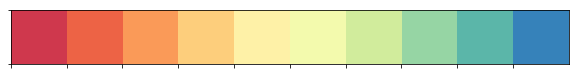

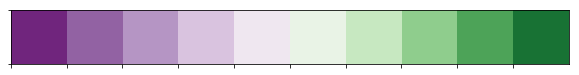

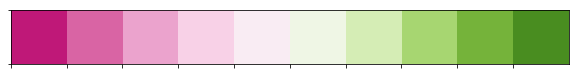

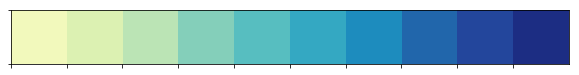

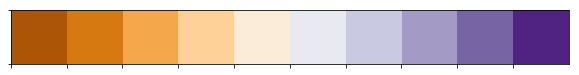

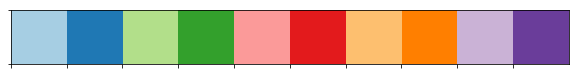

In [62]:
%matplotlib inline
import ast
from bs4 import BeautifulSoup
from config import api_key_tmdb
import csv
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import re
import requests
from scipy import stats
import seaborn as sns
sns.palplot(sns.color_palette("Spectral", 10))
sns.palplot(sns.color_palette("PRGn", 10))
sns.palplot(sns.color_palette("PiYG", 10))
sns.palplot(sns.color_palette("YlGnBu", 10))
sns.palplot(sns.color_palette("PuOr", 10))
sns.palplot(sns.color_palette("Paired", 10))
import sqlite3
from sqlite3 import Error
import time

In [113]:
# Importing the IMDB movies file
data = "/Users/florencialeoni/Documents/flatironDS/Mod_1_FP/mod1_movies/imdb_movies_data.csv"
use_cols = ["imdb_id", "imdb_score", "meta_score"]

# Using pandas.read_csv method to load the file
imdb_df = pd.read_csv(data, usecols = use_cols)
imdb_df = imdb_df.set_index("imdb_id")

# Replace missing data in the "imdb_score" and "meta_score" columns with NumPy NaN values
imdb_df["imdb_score"] = imdb_df["imdb_score"].replace(" ", np.nan)
imdb_df["meta_score"] = imdb_df["meta_score"].replace(" ", np.nan)

# Importing the TMDB Movies file
data = "/Users/florencialeoni/Documents/flatironDS/Mod_1_FP/mod1_movies/tmdb_movies_cast_df.csv"

# Using pandas.read_csv method to load the file
tmdb_df = pd.read_csv(data, lineterminator='\n')
tmdb_df = tmdb_df.set_index("id")
tmdb_df = tmdb_df.merge(imdb_df, how = "left", on = "imdb_id")

# Using pandas.to_numeric to coerce the "id", "budget" and "revenue" columns into numbers
tmdb_df["budget"] = pd.to_numeric(tmdb_df["budget"], downcast = "integer", errors = "coerce")
tmdb_df["revenue"] = pd.to_numeric(tmdb_df["revenue"], downcast = "integer", errors = "coerce")

# Lambda function to strip and split "release_date" string values
f = lambda x: str(x).strip().split('-')[0] if x != np.nan else np.nan

# Creating a new column, "year", and assigninf the value of "release_date" 
# After applying the lambda function through map
tmdb_df["year"] = tmdb_df["release_date"].map(f)

# Coerce the "year" column to integers
tmdb_df["year"] = pd.to_numeric(tmdb_df["year"], errors = "coerce")

# Convert "release_date" column to datetime format
tmdb_df["release_date"] = pd.to_datetime(tmdb_df["release_date"])

# Divide "release_date" column in months
tmdb_df["month_of_year"] = tmdb_df["release_date"].dt.month_name()

# Divide "release_date" column in months
tmdb_df["day_of_week"] = tmdb_df["release_date"].dt.day_name()

# Create a subset of the main DataFrame focused on genres
genres_df = tmdb_df[tmdb_df["genres"].notnull()][["title","budget", "revenue", "runtime", "year", 
                        "month_of_year", "day_of_week", "popularity", "imdb_score", "meta_score", "genres"]]

# Unpack the values in the genre column using the ast module
genres_df["genres"] = genres_df["genres"].apply(ast.literal_eval)

# Add a column to account for each genre of each movie to the genres_df subset
genres = genres_df["genres"]
genres = genres.apply(pd.Series)
genres = genres.rename(columns = lambda x : 'genre_' + str(x))
genres_df = pd.concat([genres_df[:], genres[:]], axis=1)

# Drop the release date column as we have extracted its information
tmdb_df = tmdb_df.drop(["release_date"], axis=1)

# Create a subset of the main DataFrame focused on the revenue
tmdb_df_revenue = tmdb_df[tmdb_df["revenue"].notnull()][["title", "budget", "revenue", "year", 
                        "month_of_year", "day_of_week", "popularity", "vote_average", 
                            "production_companies", "director_name", "leading_actor_name", "vote_count"]]

# Drop columns for which budget is a null value
tmdb_df_revenue = tmdb_df_revenue.dropna(subset=["budget"])

# Create a new column to hold the value of the ROI
tmdb_df_revenue["roi"] = ((tmdb_df_revenue["revenue"] - tmdb_df_revenue["budget"]) / tmdb_df_revenue["budget"])

# Drop the numbers that are too small
tmdb_df_revenue = tmdb_df_revenue.drop(tmdb_df_revenue[tmdb_df_revenue.budget < 5000].index)
tmdb_df_revenue = tmdb_df_revenue.drop(tmdb_df_revenue[tmdb_df_revenue.revenue < 5000].index)

# Subset of less popular movies
less_popular = tmdb_df[tmdb_df["popularity"].notnull()][["title", "tagline", 
                        "popularity", "year", "overview", "director_name", 
                        "leading_actor_name", "supporting_actor_name", "budget"]].sort_values("popularity").head(100)

# Function to create a new SQLite3 Database
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    finally:
        conn.close()
        
# Use create_connection function to create Database
create_connection("/Users/florencialeoni/Documents/flatironDS/Mod_1_FP/mod1_movies/movies.db")

# Create a connection object using the connect function 
# To establish a connection with "movies.db"
connection = sqlite3.connect("movies.db")
# Create a cursor object by calling the cursor method
cursor = connection.cursor()

# Initial analysis of relationships between the numeric variables in the dataset

Below we see a pairplot constructed using the Seaborn library. This is a useful visualization to quickly detect patterns hidden in the data.

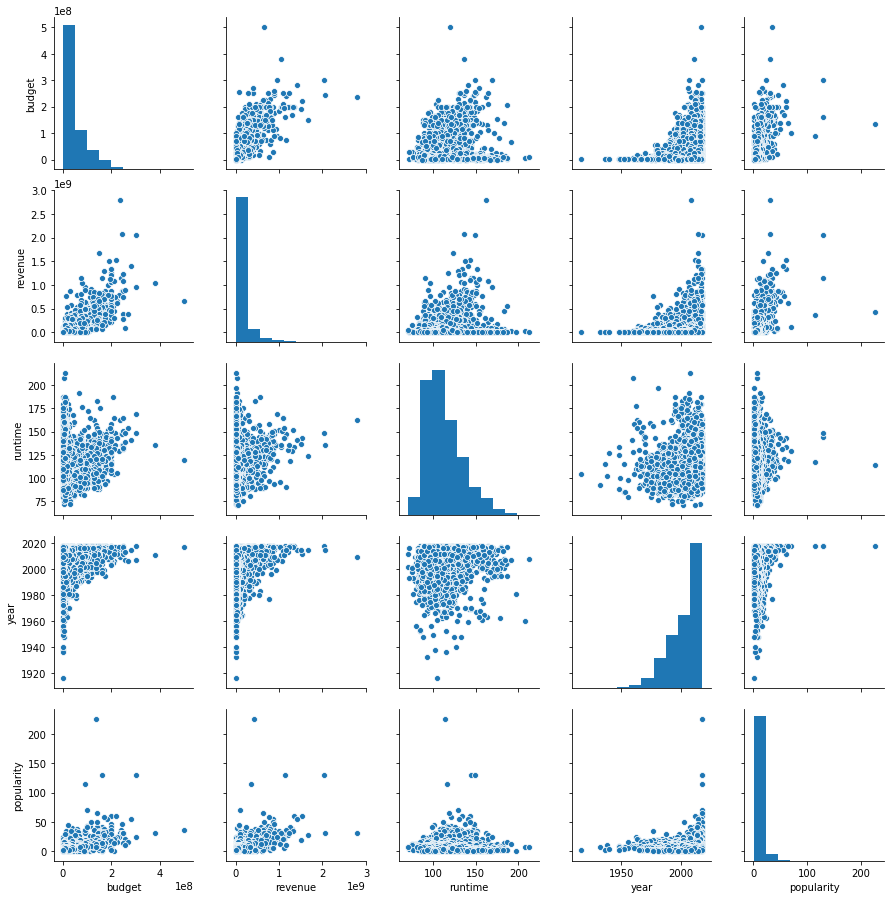

In [6]:
pairplot = tmdb_df[tmdb_df["revenue"].notnull()][["title", "budget", "revenue", "runtime", "year", 
                                        "month_of_year", "day_of_week", "popularity"]]
sns.pairplot(pairplot)
plt.show()

If we further explore this relationships in a correlation matrix, we can see that there is a strong correlation between vote_count and revenue, and vote count and budget. Could this be by chance, or is there something else happening here? We can also see, as expected a strong relationship between revenue and budget, just as we saw above.

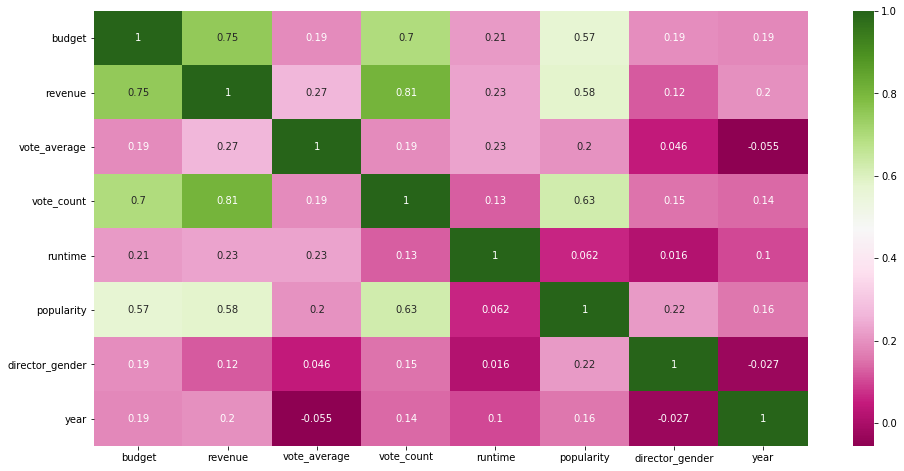

In [22]:
plt.figure(figsize = (16, 8))
sns.heatmap(tmdb_df.corr(), annot = True, cmap = "PiYG")

# A tale of days and months...

One of the first patterns we analyzed was the amount of movies released per day of the week, and per month of the year, versus the days and months where a release would make the highest average revenue.

[Text(0, 0.5, 'Movie Count'), Text(0.5, 0, 'Days of the Week')]

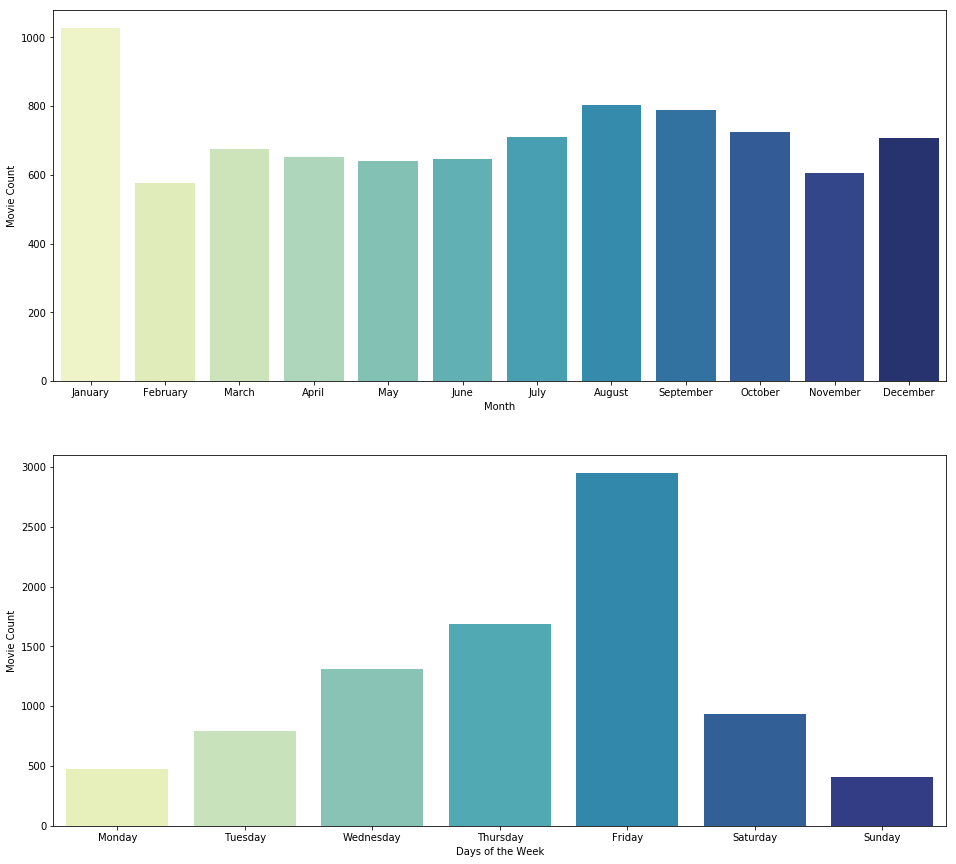

In [117]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(16, 15))
ax = sns.countplot(x = "month_of_year", data = tmdb_df, palette = "YlGnBu", ax = axes[0], order = ["January", "February", 
                                                                              "March", "April", "May",
                                                                             "June", "July", "August",
                                                                             "September", "October",
                                                                             "November", "December"])
ax.set(xlabel = "Month", ylabel = "Movie Count")
ax2 = sns.countplot(x = "day_of_week", data = tmdb_df, palette = "YlGnBu", ax = axes[1], order = ["Monday", "Tuesday", 
                                                                              "Wednesday", "Thursday", "Friday",
                                                                             "Saturday", "Sunday"])
ax2.set(xlabel = "Days of the Week", ylabel = "Movie Count")

And even though more movies are released in January, and on Fridays, data shows those days are not the ones with the highest average revenue. On the contrary, the moths with the highest mean revenue are May and June, closely followed by December and April; and the days of the week with the highest mean revenue are Tuesday and Wednesday.

[Text(0, 0.5, 'Average Revenue'), Text(0.5, 0, 'Days of the Week')]

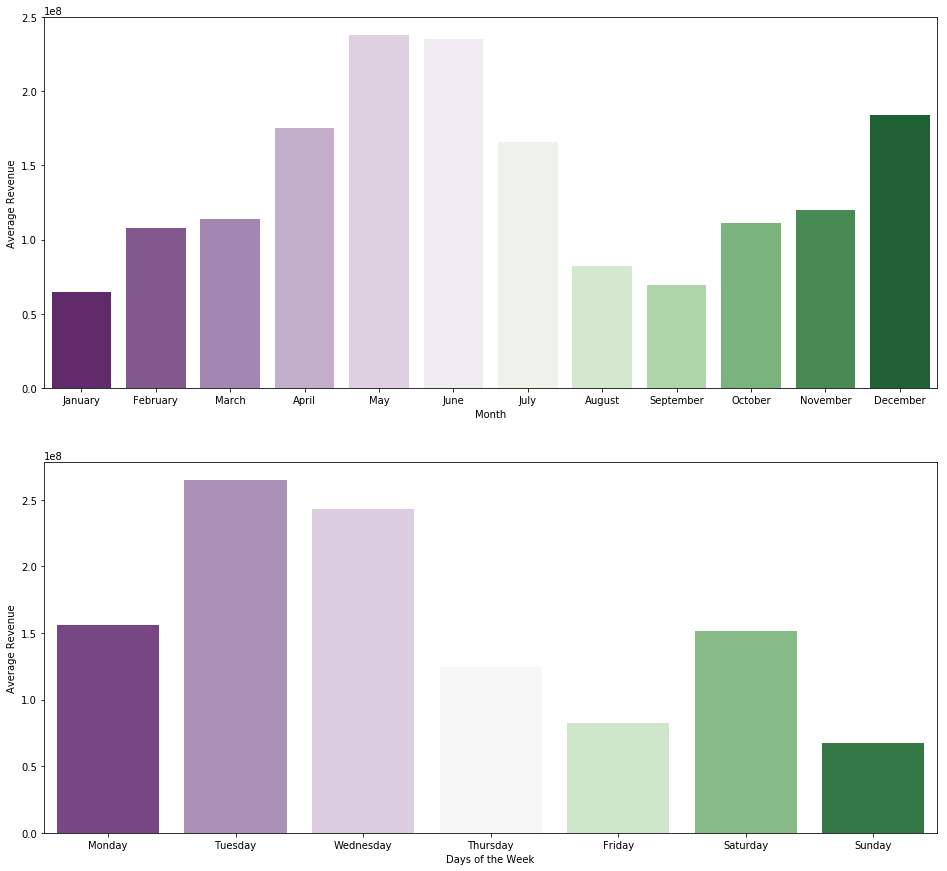

In [118]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(16, 15))
month_df = tmdb_df_revenue[tmdb_df_revenue["month_of_year"].notnull()][["revenue", "month_of_year"]]
avg_rev_month = month_df.groupby("month_of_year").mean()
avg_rev_month.reset_index(inplace = True)
ax = sns.barplot(x = "month_of_year", y = "revenue", palette = "PRGn", ax = axes[0], data = avg_rev_month, order = ["January", "February", 
                                                                              "March", "April", "May",
                                                                             "June", "July", "August",
                                                                             "September", "October",
                                                                             "November", "December"])
ax.set(xlabel = "Month", ylabel = "Average Revenue")

day_df = tmdb_df_revenue[tmdb_df_revenue["day_of_week"].notnull()][["revenue", "day_of_week"]]
avg_rev_day = day_df.groupby("day_of_week").mean()
avg_rev_day.reset_index(inplace = True)
ax2 = sns.barplot(x = "day_of_week", y = "revenue", palette = "PRGn", data = avg_rev_day, ax = axes[1], order = ["Monday", "Tuesday", 
                                                                              "Wednesday", "Thursday", "Friday",
                                                                             "Saturday", "Sunday"])
ax2.set(xlabel = "Days of the Week", ylabel = "Average Revenue")


# The higher the budget, the higher the returns?

Many have written about this topic, and there are a lot of opinions out there about wheter or not one could make a box office with a smaller budget - Blumhouse Production specializes in micro-budget horror films; you may recognize some of their higts: The Blair Witch Project, Paranormal Activity, and Split. But this is certainly and edge case. Let's take a look at what the data tells us about revenue and budget.

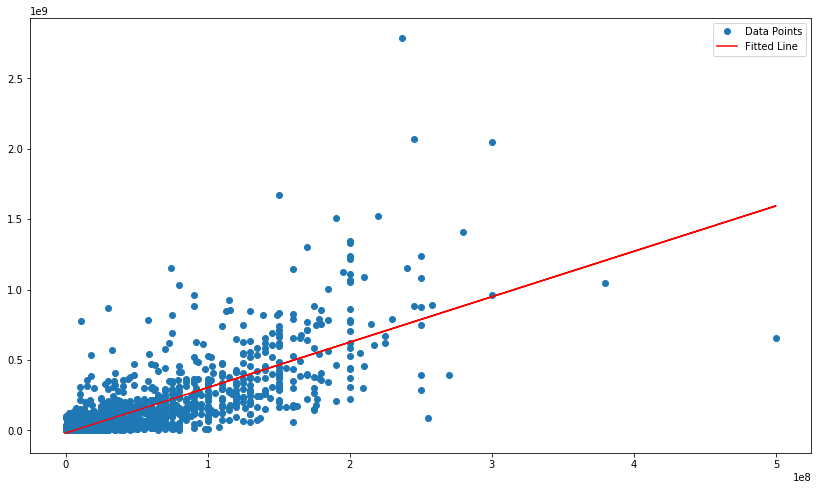

In [30]:
plt.figure(figsize=(14,8))
x = tmdb_df_revenue["budget"]
y = tmdb_df_revenue["revenue"]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
plt.plot(x, y, 'o', label = "Data Points")
plt.plot(x, intercept + slope * x, "r", label = "Fitted Line")
plt.legend()

As shown in the graph, the line is being pulled by outliers in the data, and the plot, rather than showing a strong linear relationship between budget and revenue, shows a small clustering near the origin.

# Is this a popularity contest?

As per the graph below, though initially it is clustering near the origin, there is a positive linear relationship between the vote count and the revenue. Meaning that after all the movie business IS a popularity contest.

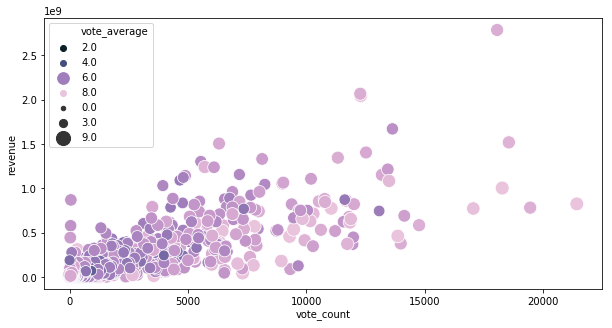

In [100]:
cmap = sns.cubehelix_palette(n_colors = 10, as_cmap = True, gamma = 1.2, start = 2.3, rot = .5, reverse = True)
plt.figure(figsize=(10,5))
sns.scatterplot(x = tmdb_df_revenue["vote_count"], y = tmdb_df_revenue["revenue"], hue = tmdb_df_revenue["vote_average"], 
                size = tmdb_df_revenue["vote_average"], palette = cmap, sizes=(20, 200), hue_norm=(2, 8), data = tmdb_df_revenue)
fig.tight_layout()


# What should the genre of the next movie be?

The first bar chart shows the average revenue per genre from 2010 to 2018. We can see how *Westerns* are considerably most succesful than the rest. However, that bar is inflated by True Grit (2012), The Revenant (2015), Django Unchained (2012), The Hateful Eight (2015), and Bone Tomahawk (2015).

Then we take a look at individual years. From in 2016 to 2018 the genre with the highest mean revenue was Adventure. In this period we have movies such as Allegient, for the Divergent Series (2016), Pete's Dragon (2016), Captain America: Civil War, from the Captain America Series (2016), The Magnificent Seven (2016), Wonder Women (2017), The Fate of the Furious, from the The Fast and the Furious Series (2017), Valerian and The City of a Thousand Planets (2017), and Pirates of the Caribbean: Dead Men Tell No Tales, from the Pirates of the Caribbean Series (2017), Avengers: Infinity Wars, from the Avengers Series (2018) and Ready Player One (2018). 

What do these have in common? *Superheroes*, *Futurism*, and *Franchises*.

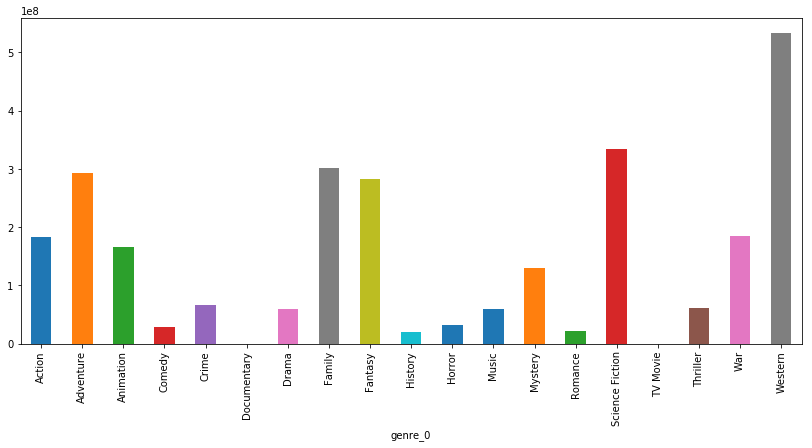

In [112]:
filtered_genres_df = genres_df[genres_df['year'] > 2010]
grouped_by = filtered_genres_df.groupby(["genre_0"])["revenue"]

grouped_by.mean().plot(kind = "bar", stacked = False, figsize = (14, 6))

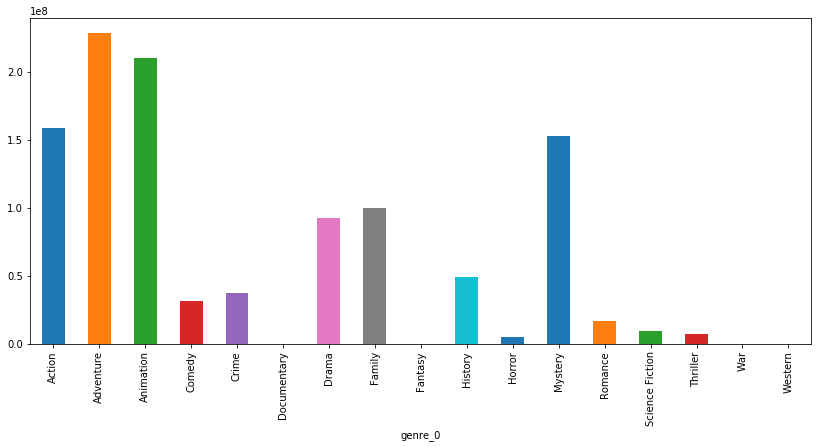

In [108]:
filtered_genres_df = genres_df[genres_df['year'] == 2016]
grouped_by = filtered_genres_df.groupby(["genre_0"])["revenue"]

grouped_by.mean().plot(kind = "bar", stacked = False, figsize = (14, 6))

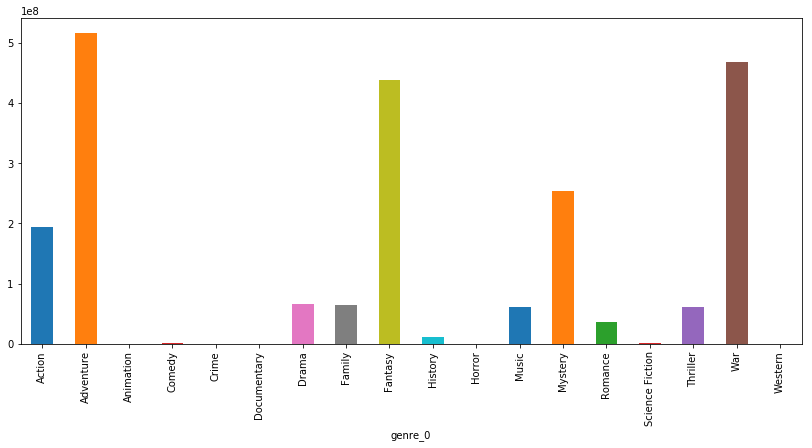

In [109]:
filtered_genres_df = genres_df[genres_df['year'] == 2017]
grouped_by = filtered_genres_df.groupby(["genre_0"])["revenue"]

grouped_by.mean().plot(kind = "bar", stacked = False, figsize = (14, 6))

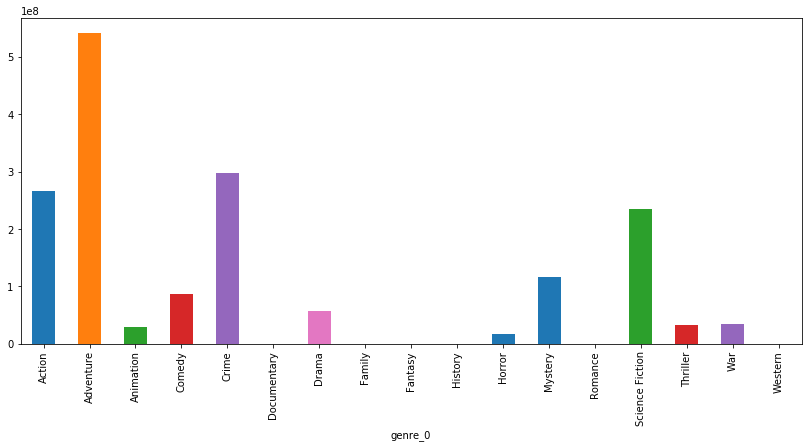

In [110]:
filtered_genres_df = genres_df[genres_df['year'] == 2018]
grouped_by = filtered_genres_df.groupby(["genre_0"])["revenue"]

grouped_by.mean().plot(kind = "bar", stacked = False, figsize = (14, 6))

# What has Lionsgate been up to...?

*Let's take a look at what Lionsgate has been up to in the last 8 years.*

From the table below we see that they've had some succeses in with franchises (The Hunger Games) and Western movies (3:10 Yuma). But not really catching up with the Superheroes and Futurism trend. Since the genre adventure is not about the adventure itself, is more about the story it tells, what the adventure is about.

In [115]:
pd.read_sql_query('''SELECT title, revenue, budget, vote_count, year, genres, popularity FROM tmdb_movies WHERE production_companies LIKE "%lionsgate%";''', connection)

,title,revenue,budget,vote_count,year,genres,popularity
0,Power Rangers,142337240.0,100000000.0,2569.0,2017.0,"['Action', 'Adventure', 'Science Fiction']",13.984
1,Sicario,84025816.0,30000000.0,4311.0,2015.0,"['Action', 'Crime', 'Thriller']",19.653
2,The Hunger Games,691210692.0,75000000.0,14140.0,2012.0,"['Science Fiction', 'Adventure', 'Fantasy']",12.830
3,The Hunger Games: Catching Fire,847423452.0,130000000.0,10790.0,2013.0,"['Adventure', 'Action', 'Science Fiction']",22.584
4,Abduction,82087155.0,35000000.0,1720.0,2011.0,"['Thriller', 'Action', 'Mystery']",15.973
5,The Hunger Games: Mockingjay - Part 1,752100229.0,125000000.0,9756.0,2014.0,"['Science Fiction', 'Adventure', 'Thriller']",26.751
6,3:10 to Yuma,70016220.0,55000000.0,1779.0,2007.0,['Western'],15.868
7,Hummingbird,8352885.0,20000000.0,823.0,2013.0,"['Action', 'Thriller']",8.928
8,Punisher: War Zone,10089373.0,20500000.0,518.0,2008.0,"['Action', 'Crime']",10.705
9,Crank: High Voltage,34560577.0,20000000.0,1377.0,2009.0,"['Action', 'Thriller', 'Crime']",12.909
